In [1]:
import pybamm
import numpy as np

In [2]:
model = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

In [3]:
parameter_values = pybamm.ParameterValues("Mohtat2020")
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})

In [4]:
# define experiments

cycles = 10
cccv_experiment = pybamm.Experiment([
    ("Charge at 1C until 4.2V", 
     "Hold at 4.2V until C/50",
     "Discharge at 1C until 3V",
     "Rest for 1 hour",
    )
] * cycles)
charge_experiment = pybamm.Experiment([
    ("Charge at 1C until 4.2V", 
     "Hold at 4.2V until C/50",
    )
])
# is this right?
rpt_experiment = pybamm.Experiment([
    ("Discharge at C/3 until 3V",)
])

In [5]:
# simulate cccv
sim = pybamm.Simulation(model, experiment=cccv_experiment, parameter_values=parameter_values)
cccv_sol = sim.solve()

In [6]:
pybamm.dynamic_plot(cccv_sol, ["Current [A]", "Voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=31.016705015131166, step=0.31016705015131163…

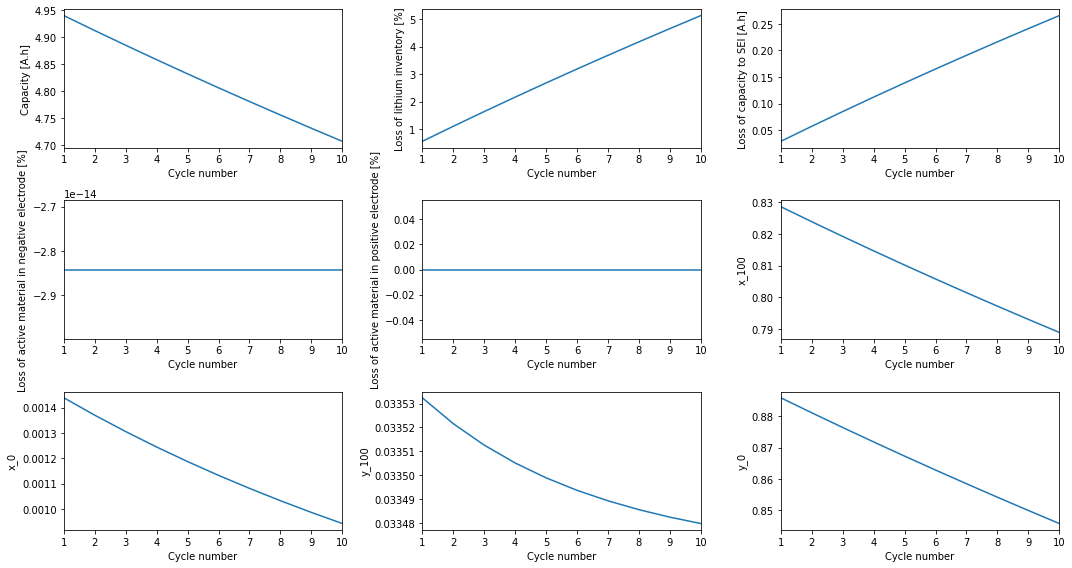

In [7]:
pybamm.plot_summary_variables(cccv_sol);

In [8]:
# option 1, do the charge then the RPT
sim = pybamm.Simulation(model, experiment=charge_experiment, parameter_values=parameter_values)
charge_sol = sim.solve(starting_solution=cccv_sol)
sim = pybamm.Simulation(model, experiment=rpt_experiment, parameter_values=parameter_values)
rpt_sol = sim.solve(starting_solution=charge_sol)

In [9]:
pybamm.dynamic_plot(rpt_sol.cycles[-1], ["Current [A]", "Voltage [V]"])

interactive(children=(FloatSlider(value=32.160212091735325, description='t', max=34.91096408712699, min=32.160…

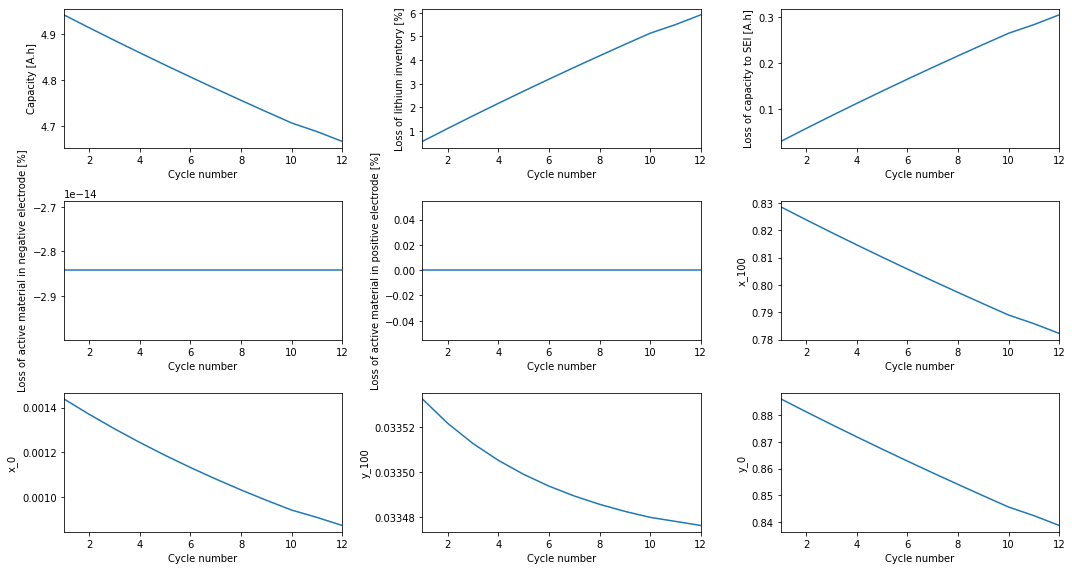

In [10]:
pybamm.plot_summary_variables(rpt_sol);

In [11]:
# option 2, set soc then do the RPT
x0 = cccv_sol.summary_variables["x_0"][-1]
x100 = cccv_sol.summary_variables["x_100"][-1]
y0 = cccv_sol.summary_variables["y_0"][-1]
y100 = cccv_sol.summary_variables["y_100"][-1]

In [12]:
target_soc = 1
x = x0 + target_soc * (x100-x0)
y = y0 - target_soc * (y0-y100)
cs_neg = x * parameter_values["Maximum concentration in negative electrode [mol.m-3]"]
cs_pos = y * parameter_values["Maximum concentration in positive electrode [mol.m-3]"]

In [13]:
sim = pybamm.Simulation(model, experiment=rpt_experiment, parameter_values=parameter_values)
sim.build_for_experiment()
y_slices = list(sim.op_conds_to_built_models.values())[0].y_slices

In [14]:
scales = [var.scale for var in list(list(sim.op_conds_to_built_models.values())[0].y_slices.keys())]

In [30]:
final_state = cccv_sol.last_state
y = final_state.y
y[0:20] = np.ones((20,1)) * cs_neg / scales[0].value
y[20:40] = np.ones((20,1)) * cs_pos /  scales[1].value
my_sol = pybamm.Solution(
    final_state.t, 
    y, 
    final_state.all_models, 
    final_state.all_inputs,
    final_state.t_event,
    final_state.y_event,
    final_state.termination,
)
my_sol.solve_time = final_state.solve_time
my_sol.integration_time = final_state.integration_time
my_sol.set_up_time = final_state.set_up_time

In [31]:
rpt_sol = sim.solve(starting_solution=my_sol)

In [32]:
pybamm.dynamic_plot(rpt_sol.cycles[-1], ["Current [A]", "Voltage [V]"])

interactive(children=(FloatSlider(value=31.016705015131443, description='t', max=33.78342937631853, min=31.016…